In [1]:
from typing import (
    List,
    Dict,
    Any,
    Tuple,
    Callable,
    Union,
    Optional,
)
import os
import sys
import logging

import numpy as np
import matplotlib.pyplot as plt

# Data

```
X: (sepal length in cm, sepal width in cm)
Y: 0 for Iris-Setosa, 1 for Iris-Versicolour
```

In [2]:
def standardize(X: np.ndarray) -> np.ndarray:
    return (X - np.mean(X, axis=0)) / np.std(X)

In [3]:
from sklearn import datasets

iris = datasets.load_iris()

X = standardize(iris.data[:, :2][iris.target != 2])
T = iris.target[[iris.target != 2]][
    :,
    np.newaxis
]  # Must be (N, 1) shape. For each X[i], there needs to be corresponding T[i]

assert T.shape == (X.shape[0], 1)

/tmp/ipykernel_18360/1210732872.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T = iris.target[[iris.target != 2]][


In [4]:
T[0:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [5]:
print(f"X.shape {X.shape}, Y.shape {T.shape}")

X.shape (100, 2), Y.shape (100, 1)


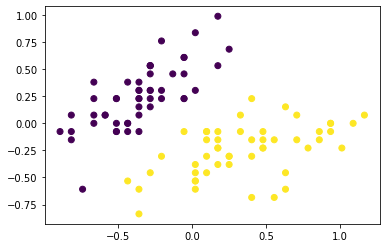

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=T.reshape(-1))

# Logistic regresssion

Decision boundray $W \cdot X >=0$ for ```Y=1```.

In [7]:
N: int        # Number of data points
D: int        # Dimension of each data point x
M: int = 1    # Output dimension of X•W
(N, D) = X.shape
(N, D)

(100, 2)

In [52]:
# weight in row level matrix in shape (M, D)
W: np.ndarray = np.random.randn(M, D).astype(np.float32) / np.sqrt(D)

## Prediction 

In [53]:
def predict(x: np.ndarray, w: np.ndarray) -> np.ndarray:
    n, D = x.shape
    
    y = np.einsum("nd,md->nm", x, w)
    assert y.shape == (n, M)
    return y

Y = predict(x=X, w=W)
assert Y.shape == (N, M)

## Binary classifiation

In [54]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

Z: np.ndarray = sigmoid(Y)
assert Z.shape == (N, M)

## Cross entropy log loss

$Loss = -[Tlog(Z) + (1-Z)(log(1-Z)]$

/tmp/ipykernel_18360/4044681563.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(_x, -np.log(_x), label="-log(x)")
/tmp/ipykernel_18360/4044681563.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(_x, -np.log(1 - _x), label="-log(1-x)")


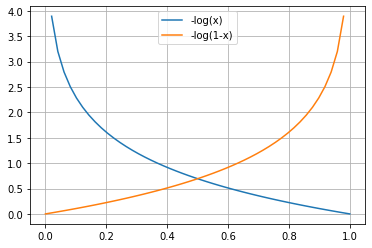

In [55]:
_x: np.ndarray = np.linspace(0, 1, num=50)
plt.plot(_x, -np.log(_x), label="-log(x)")
plt.plot(_x, -np.log(1 - _x), label="-log(1-x)")
plt.legend()
plt.grid()
plt.show()

In [57]:
def log_loss(z: np.ndarray, t:np.ndarray) -> np.ndarray:
    (n, m) = z.shape
    
    cross_entropy_log: np.ndarray = -(t * np.log(z) + (1-t) * np.log(1 - z))
    assert cross_entropy_log.shape == (n, M)
        
    loss: np.ndarray = np.sum(cross_entropy_log)
    assert loss.shape == ()    
    return loss
    

L: np.ndarray = log_loss(z=Z, t=T)
print(L.shape)    # () scalar

()


# Gradient descent


$\frac {dL}{dZ} = \frac {1}{N} *  \frac {Z-T}{Z(1-Z)}$ is shape ```(N, M)``` as the shape L is ```()```.

$\frac {dZ}{dY} = Z(1-Z)$

$\frac {dY}{dW} = X$ is shape ```(N, D)```


$\frac {dL}{dW} = \frac {dY}{dW} \cdot \frac {dZ}{dY} \cdot \frac {dL}{dZ} = \frac {X(Z-T)} {N}$ is shape ```(M, D)```

In [58]:
LR: np.ndarray = np.array(0.1)      # Learning rate
epoch: int = 50000                  # number of iterations

In [59]:
Y = predict(x=X, w=W)
assert Y.shape == (N, M)

Z = sigmoid(Y)
assert Z.shape == (N, M)

In [60]:
def gradient_descent(x: np.ndarray, w: np.ndarray, t: np.ndarray, lr: np.ndarray = LR) -> np.ndarray:
    """
    dw = x(z-t) / N where x shape is (N,D) and (z-t) shape is (N, M).
    w = w - lr * dw 
    
    Args: 
        x: observations in shape (N, D)
        w: weight in shape (M, D)
        t: label in shape (N,)
        lr: learning rate
    """
    losses: List[np.ndarray] = []
    _w = np.copy(w)
        
    n, d = x.shape
    for i in range(epoch):
        y: np.ndarray = predict(x=x, w=_w)

        z: np.ndarray = sigmoid(y)
        assert z.shape == (n, M)
            
        loss: np.ndarray = log_loss(z=z, t=t)
        losses.append(loss)

        # --------------------------------------------------------------------------------
        # If T.shape is NOT reshaped to (N, 1) such as (N,) then einsum fails.
        # For instance, when M=1: (z-t) = (N, 1) - (N,) -> (N, N) - (1, N) -> (N, N).
        # Then the einsim "nd,nm-md" becomes (N, D)(N, N) -> (N, N) instead of dw:(M, D)
        # --------------------------------------------------------------------------------
        dw: np.ndarray = np.einsum("nd,nm->md", x, z-t) / n
        assert dw.shape == (M, D)
    
        _w = _w - lr * dw
        assert _w.shape == (M, D)
    
    return _w, losses

# Training

In [63]:
print(W)
W_result, losses = gradient_descent(x=X, w=W, t=T, lr=LR)

[[-0.60789275 -1.1877043 ]]


In [64]:
losses[::2000]

[67.88480251700123,
 7.438455303127094,
 5.094223938971622,
 4.1246589009629835,
 3.5671533148727144,
 3.194936520690292,
 2.9241033190026138,
 2.7156912560310644,
 2.548879193019877,
 2.411415956549281,
 2.2955673158011503,
 2.1961807559877347,
 2.109674673126644,
 2.033472193860647,
 1.9656657513301679,
 1.9048090039531527,
 1.8497826814503033,
 1.7997052155854738,
 1.75387150476784,
 1.7117099154703517,
 1.6727514329895439,
 1.6366071034488272,
 1.6029512563847321,
 1.5715088352370876,
 1.5420456976457182]

In [65]:
x = np.linspace(-1, 1, 11)
y = np.linspace(-1, 1, 11)
xx, yy = np.meshgrid(x, y)
X_test = np.c_[xx.ravel(), yy.ravel()]

In [66]:
T_test = (sigmoid(predict(X_test, W_result)) > 0.5).astype(int)

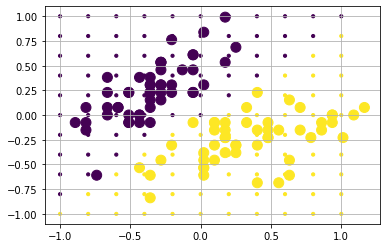

In [67]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=T_test.reshape(-1), s=10)
plt.scatter(X[:, 0], X[:, 1], c=T.reshape(-1), s=100, marker="o")
plt.grid()